# Unsupervised Learning: Trade&Ahead

### Objective

Trade&Ahead is a financial consultancy firm who provide their customers with personalized investment strategies. They have hired me as a Data Scientist and provided me with data comprising stock price and some financial indicators for a few companies listed under the New York Stock Exchange. They have assigned me the tasks of analyzing the data, grouping the stocks based on the attributes provided, and sharing insights about the characteristics of each group.

### Data Dictionary

- Ticker Symbol: An abbreviation used to uniquely identify publicly traded shares of a particular stock on a particular stock market
- Company: Name of the company
- GICS Sector: The specific economic sector assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- GICS Sub Industry: The specific sub-industry group assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- Current Price: Current stock price in dollars
- Price Change: Percentage change in the stock price in 13 weeks
- Volatility: Standard deviation of the stock price over the past 13 weeks
- ROE: A measure of financial performance calculated by dividing net income by shareholders' equity (shareholders' equity is equal to a company's assets minus its debt)
- Cash Ratio: The ratio of a  company's total reserves of cash and cash equivalents to its total current liabilities
- Net Cash Flow: The difference between a company's cash inflows and outflows (in dollars)
- Net Income: Revenues minus expenses, interest, and taxes (in dollars)
- Earnings Per Share: Company's net profit divided by the number of common shares it has outstanding (in dollars)
- Estimated Shares Outstanding: Company's stock currently held by all its shareholders
- P/E Ratio: Ratio of the company's current stock price to the earnings per share 
- P/B Ratio: Ratio of the company's stock price per share by its book value per share (book value of a company is the net difference between that company's total assets and total liabilities)

## Importing libraries and data

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

#this will allow you to scale numerical variables to z zcores
from scipy.stats import zscore

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to suppress warnings
import warnings
warnings.filterwarnings("ignore")

#this package looks at all the columns in your dataframe and identifies possible cleaning tasks that need to be done, saving a massive amount of time and code.
from pandas_dq import dq_report as dqr

Imported pandas_dq (1.12). Always upgrade to get latest features.



## Data Overview

In [2]:
#import Data
data=pd.read_csv('stock_data.csv')

#quick look at imported data and associated stats
print(data.head())
print(data.shape)
print(data.describe())

  Ticker Symbol                 Security             GICS Sector  \
0           AAL  American Airlines Group             Industrials   
1          ABBV                   AbbVie             Health Care   
2           ABT      Abbott Laboratories             Health Care   
3          ADBE        Adobe Systems Inc  Information Technology   
4           ADI     Analog Devices, Inc.  Information Technology   

       GICS Sub Industry  Current Price  Price Change  Volatility  ROE  \
0               Airlines      42.349998      9.999995    1.687151  135   
1        Pharmaceuticals      59.240002      8.339433    2.197887  130   
2  Health Care Equipment      44.910000     11.301121    1.273646   21   
3   Application Software      93.940002     13.977195    1.357679    9   
4         Semiconductors      55.320000     -1.827858    1.701169   14   

   Cash Ratio  Net Cash Flow  Net Income  Earnings Per Share  \
0          51     -604000000  7610000000               11.39   
1          77     

In [3]:
#print mean values for columns in each grouped economic sector
econsector_mean=data.groupby(['GICS Sector']).mean().reset_index()
print(econsector_mean)

                    GICS Sector  Current Price  Price Change  Volatility  \
0        Consumer Discretionary     128.095404      5.846093    1.595478   
1              Consumer Staples      71.972807      8.684750    1.152675   
2                        Energy      46.042334    -10.228289    2.568777   
3                    Financials      58.659183      3.865406    1.267255   
4                   Health Care     132.048250      9.585652    1.541023   
5                   Industrials      74.411807      2.833127    1.416989   
6        Information Technology      63.548485      7.217476    1.659801   
7                     Materials      76.551501      5.589738    1.816726   
8                   Real Estate      90.976925      6.205548    1.206053   
9   Telecommunications Services      32.964000      6.956980    1.341612   
10                    Utilities      52.968542      0.803657    1.118018   

          ROE  Cash Ratio  Net Cash Flow    Net Income  Earnings Per Share  \
0   44.90

## Exploratory Data Analysis (EDA)

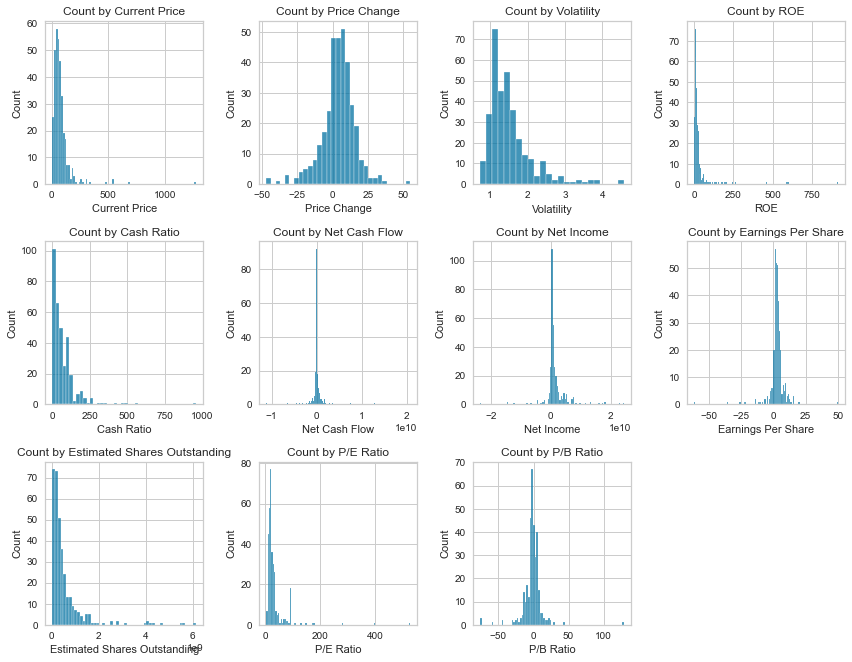

In [4]:
#Univariate Analysis
# look at the distribution of all numeric variables 
numeric_columns= data.select_dtypes(include='number').columns
num_data=data[numeric_columns]
fig = plt.figure(figsize=(12, 12))  # Set the figure size to 12x12 inches

#create forloop to graph distriution all at once
for i, var in enumerate(num_data):
    ax=fig.add_subplot(4,4, i+1)
    sns.histplot(data=data, x=var)
    ax.set_title('Count by {}'.format(var))  # Set the title
    plt.tight_layout()    
plt.show()

#### Observations
- Most of our variables have a close to normal distribution but Current Price, Estimated Shares Outstanding, P/E Ratio, ROE and Volatility are all right tailed distributions.

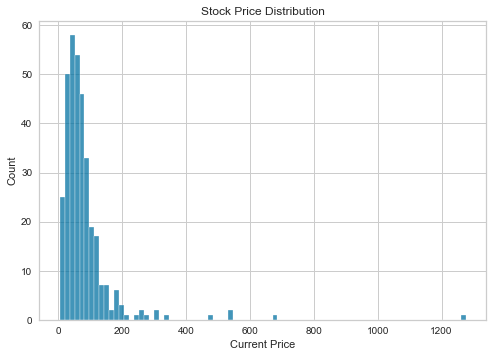

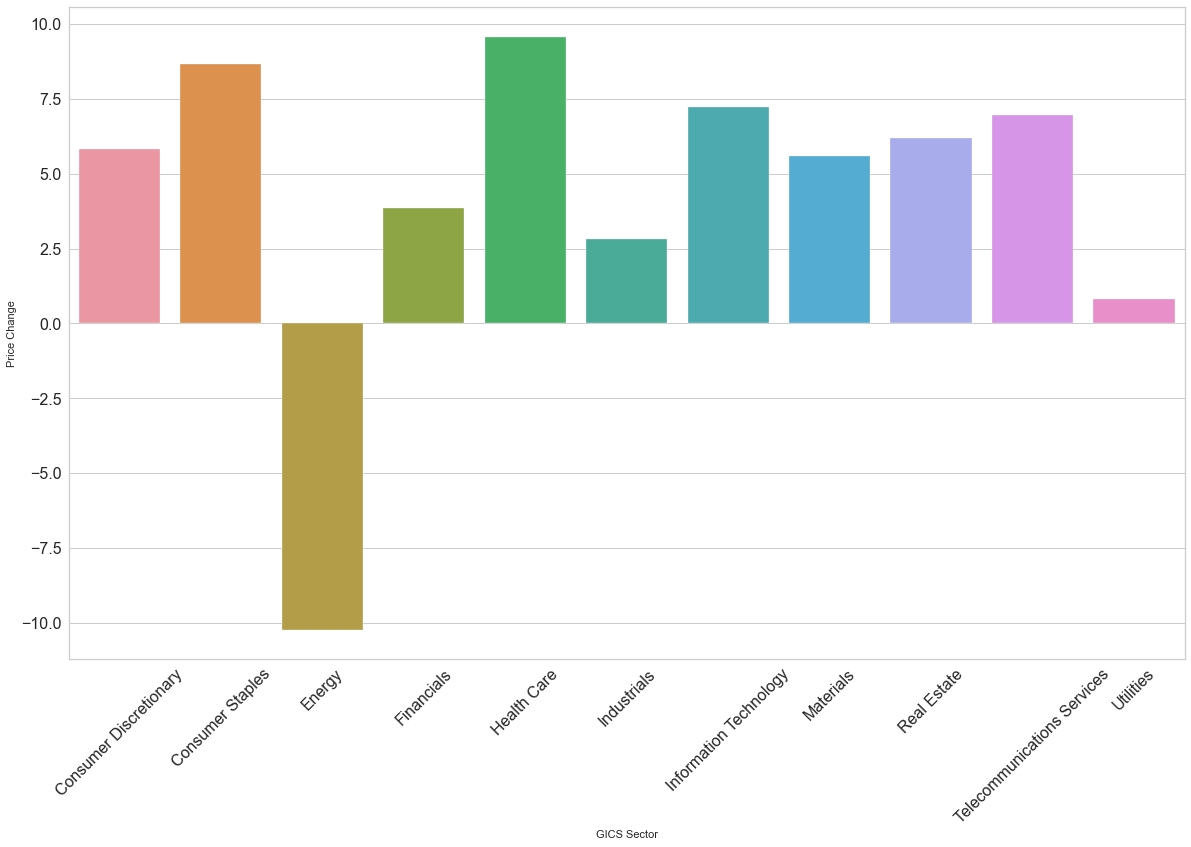

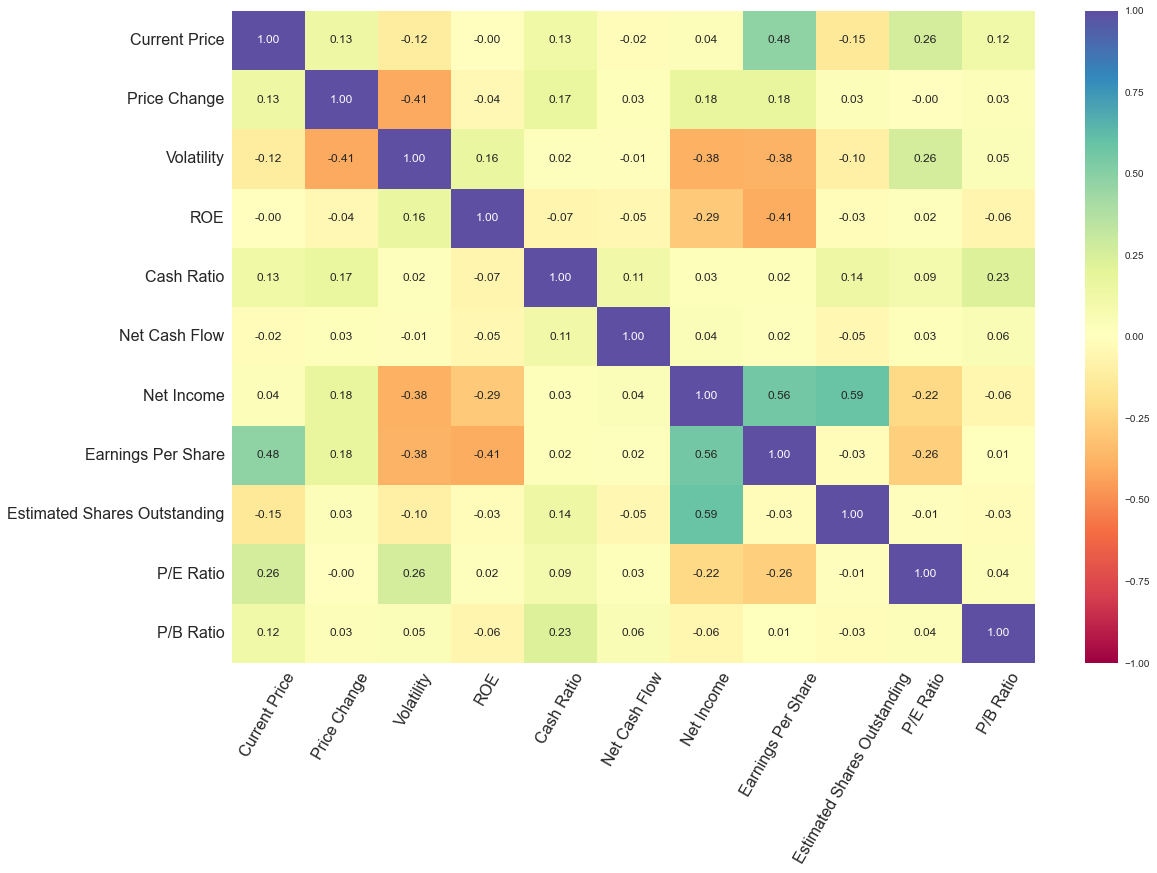

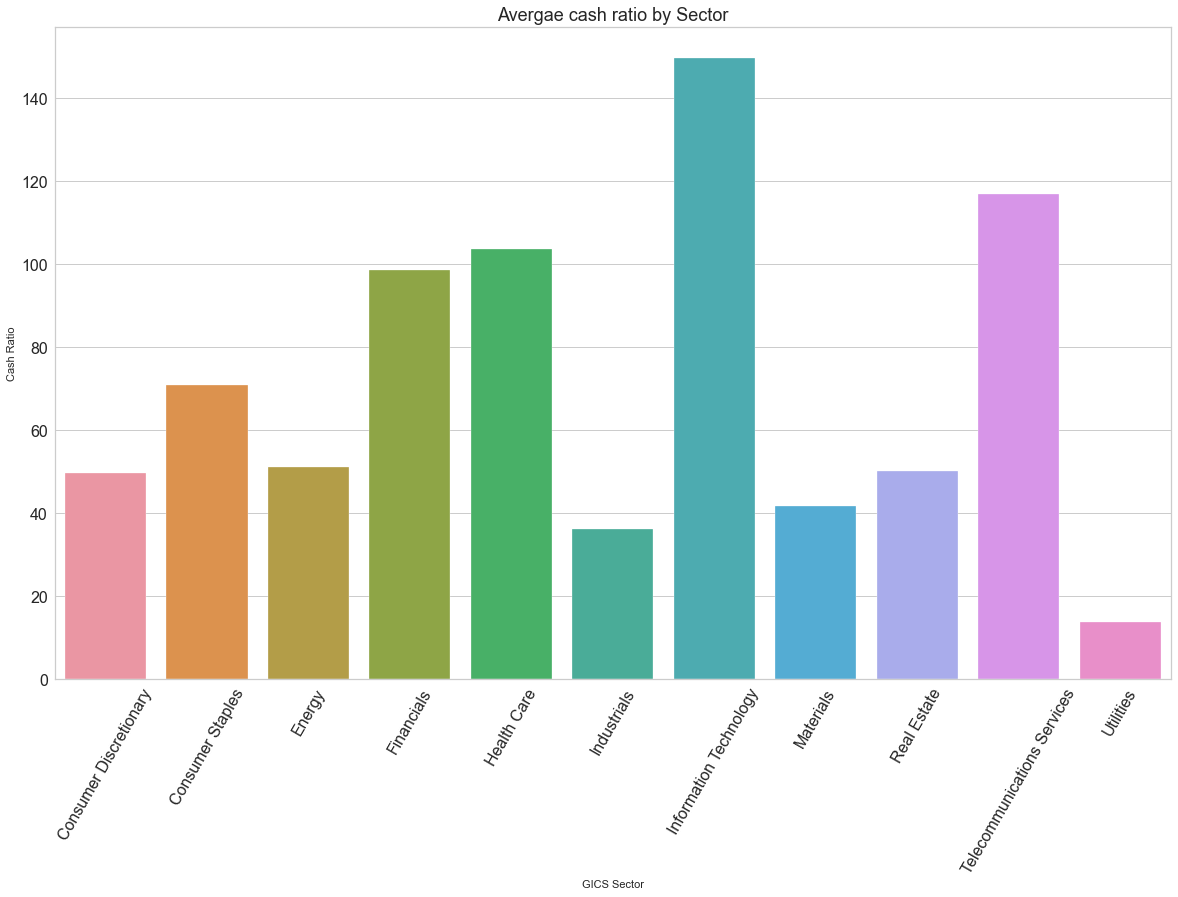

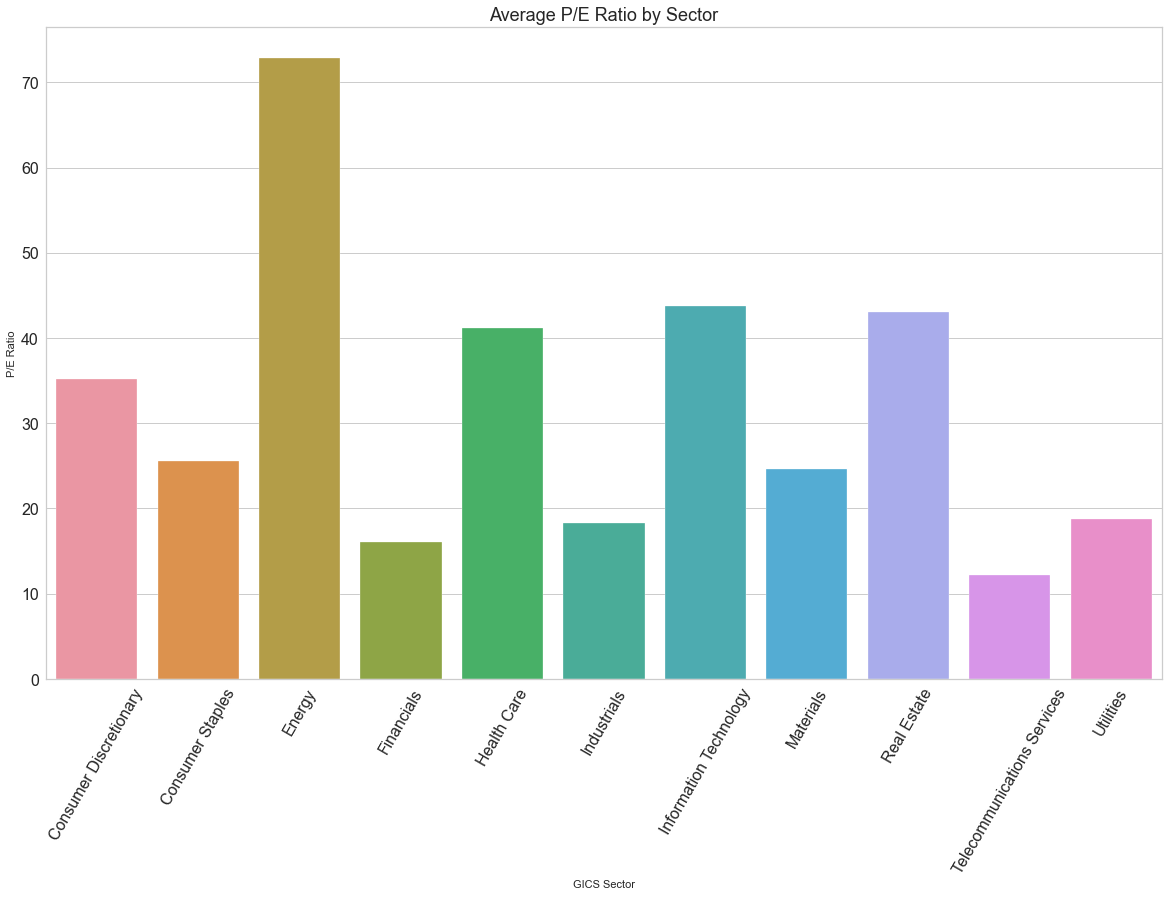

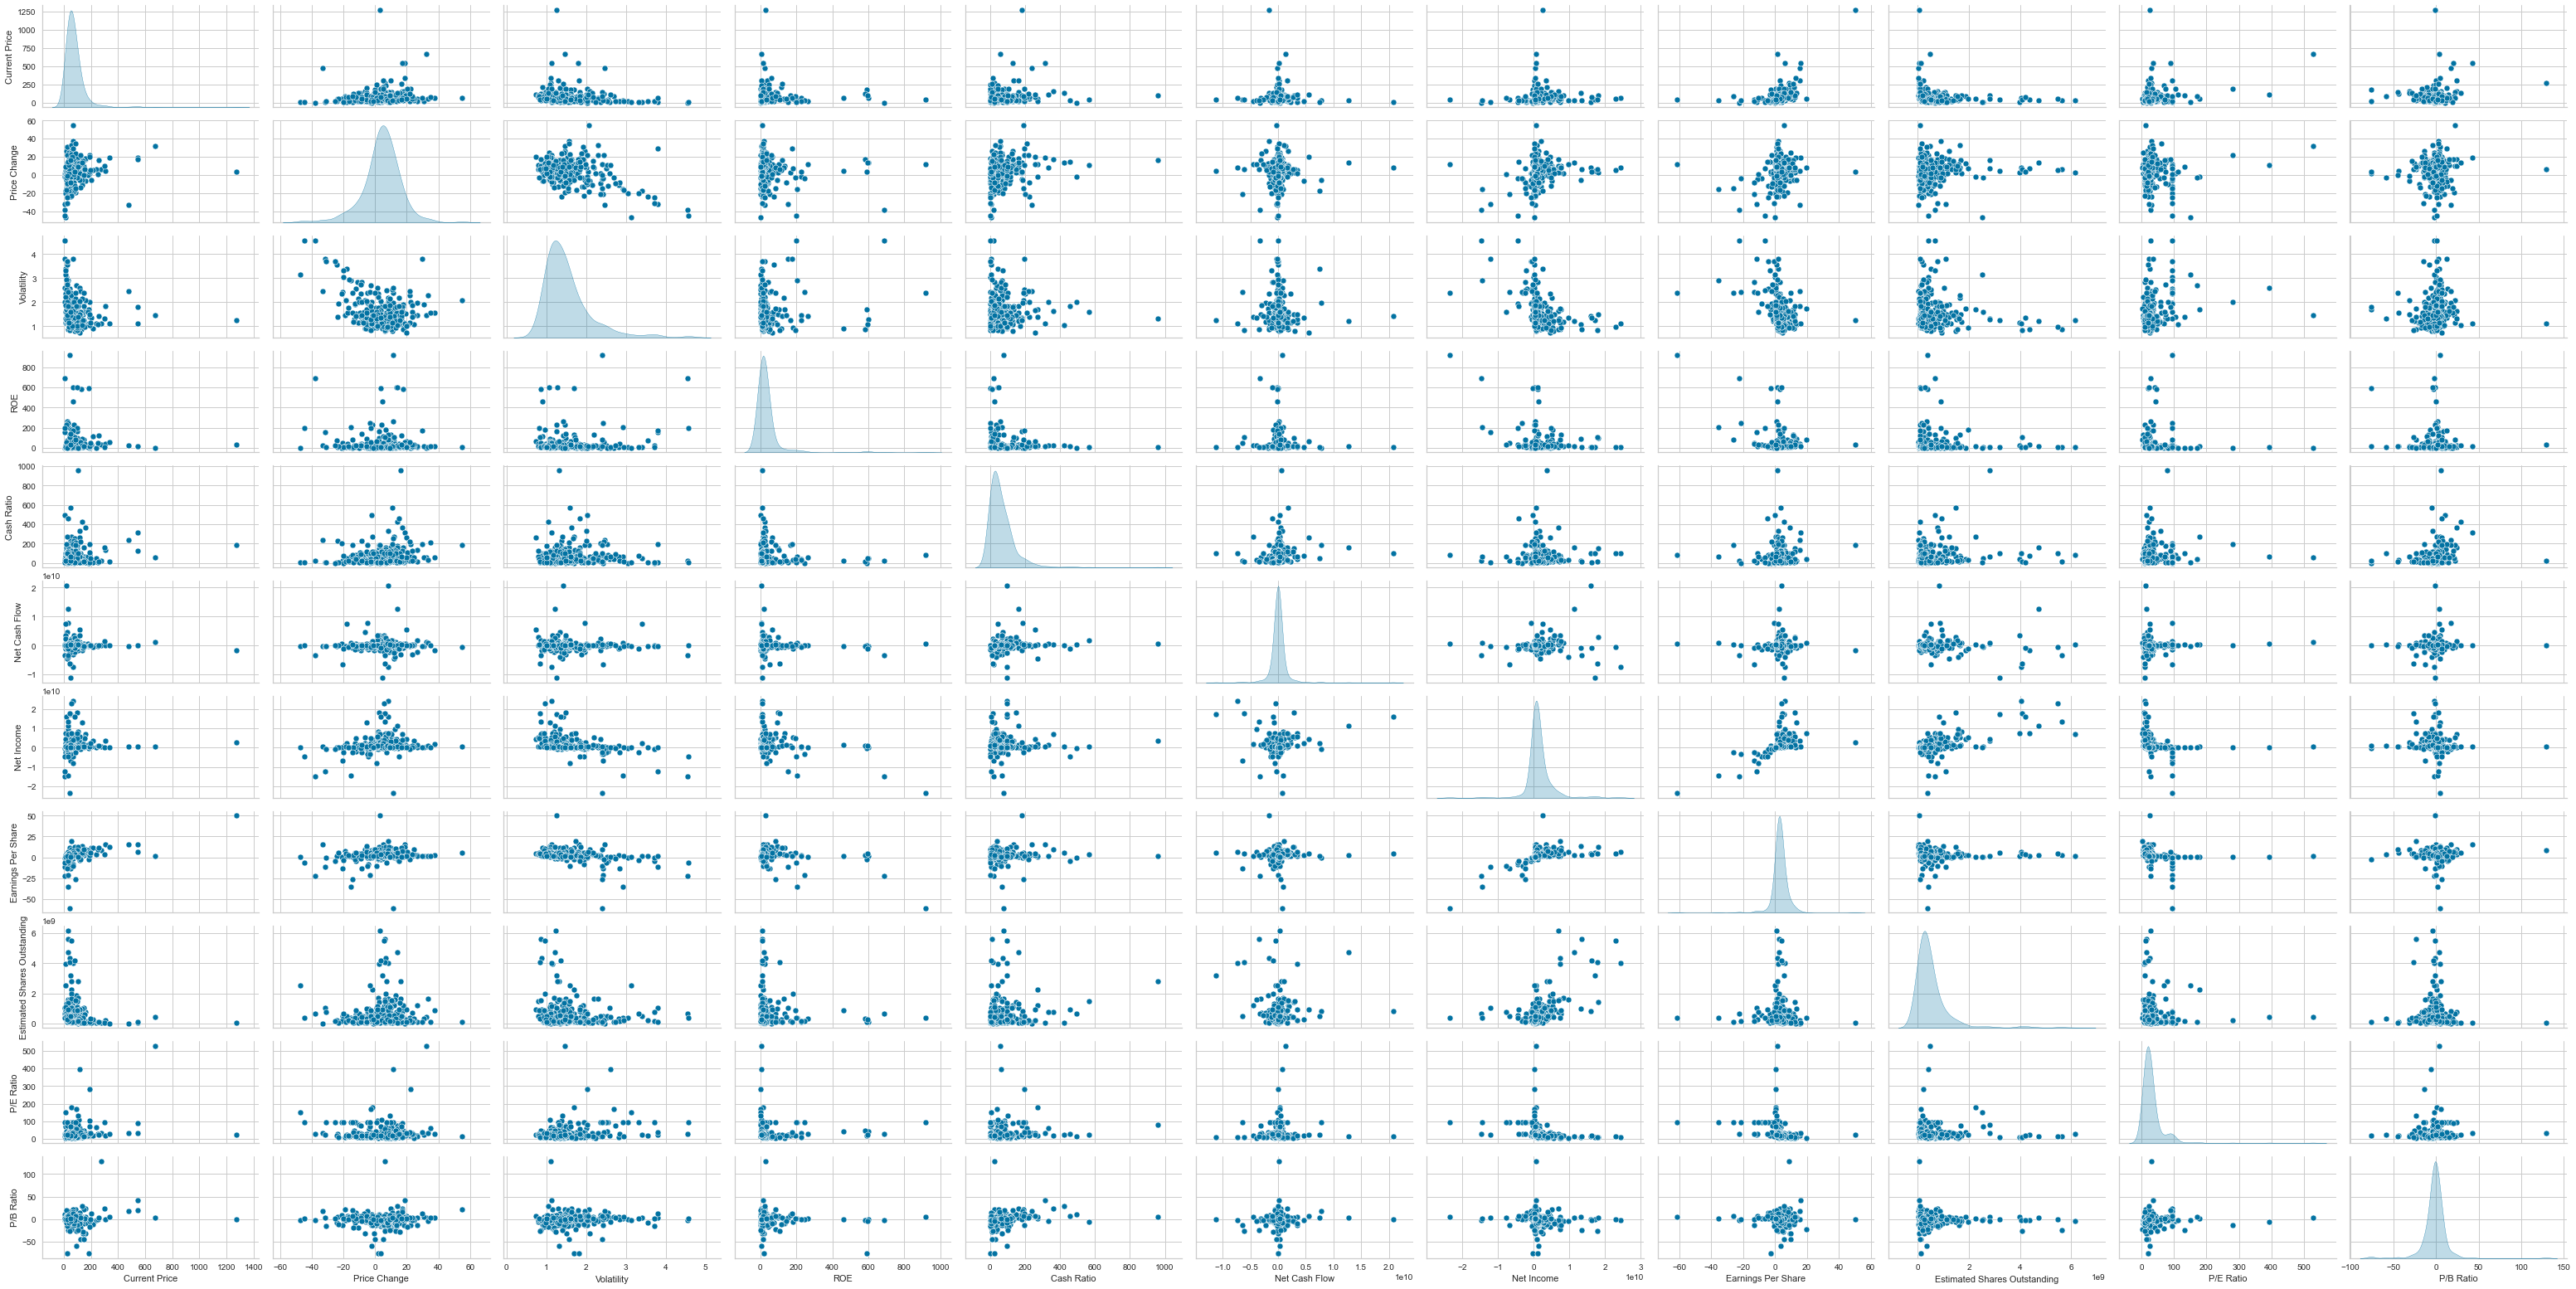

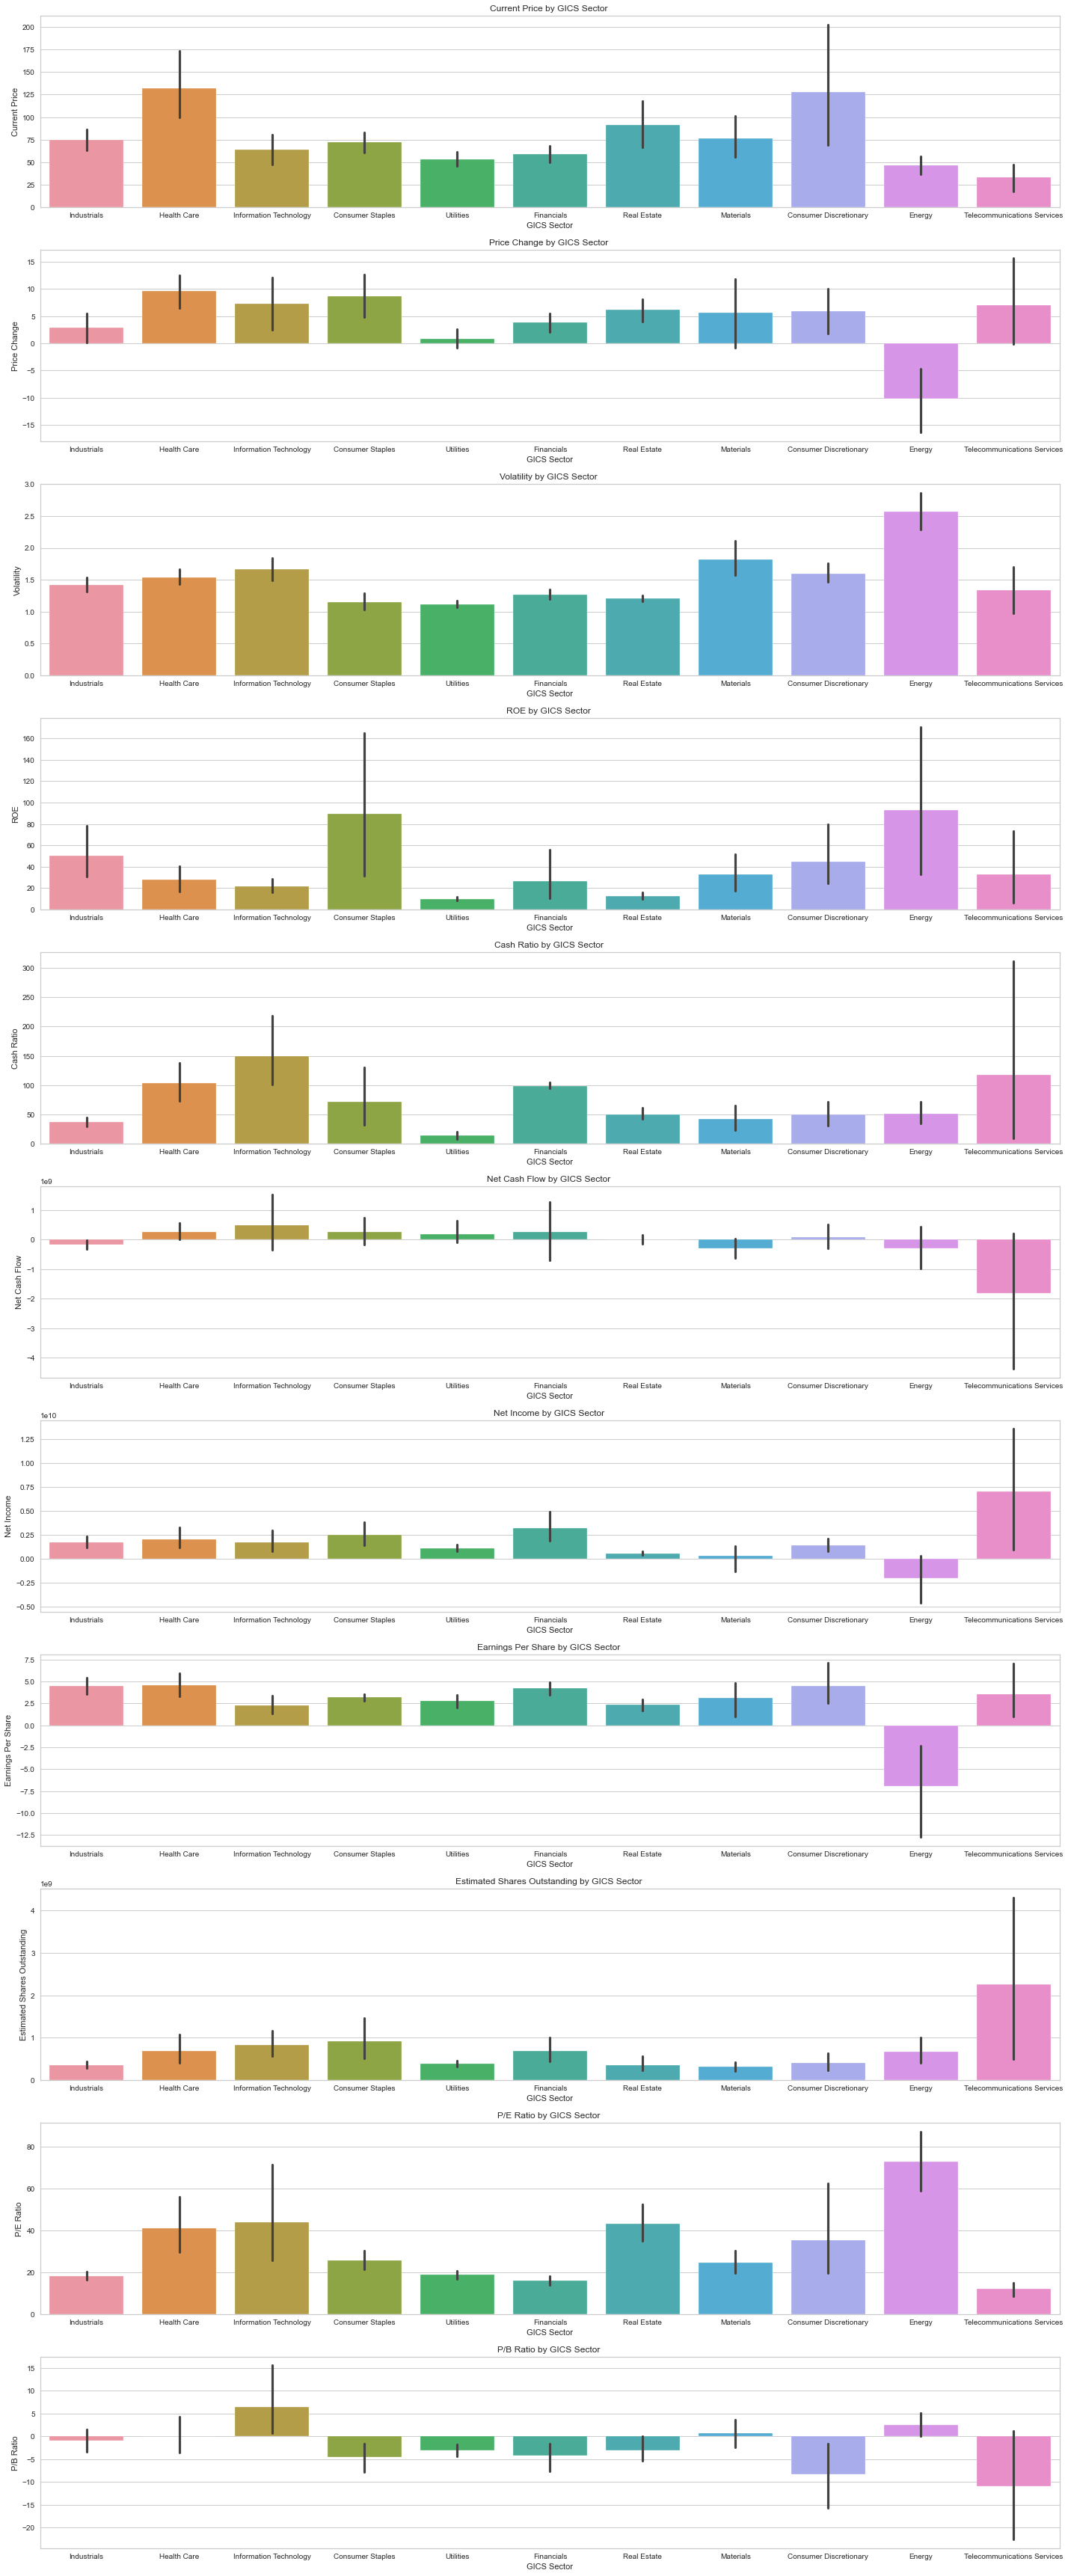

In [5]:
# 1.) Distribution of Stock Prices
sns.histplot(data=data, x='Current Price')
plt.title('Stock Price Distribution')

# 2.) Price increase by sector
plt.figure(figsize=(20,12))
sns.barplot(data=econsector_mean, x='GICS Sector', y='Price Change')
plt.xticks(rotation=45, size=16)
plt.yticks(size=16)

# 3.) Correlation between variables
numeric_variables= data.select_dtypes(include='number') #create a dataframe with only numeric variables to look at correlations
plt.figure(figsize=(18,12))
sns.heatmap(numeric_variables.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.xticks(rotation=60, size=16)
plt.yticks(size=16)
plt.show()

#4 Average cash ratio by economic sector
plt.figure(figsize=(20,12))
sns.barplot(data=econsector_mean, x='GICS Sector', y='Cash Ratio')
plt.title('Avergae cash ratio by Sector', size=18)
plt.xticks(rotation=60, size=16)
plt.yticks(size=16)

#5 P/E ratio across economic sectors 
plt.figure(figsize=(20,12))
sns.barplot(data=econsector_mean, x='GICS Sector', y='P/E Ratio')
plt.title('Average P/E Ratio by Sector', size=18)
plt.xticks(rotation=60, size=16)
plt.yticks(size=16)

#6. pairplot to look at numeric variables 
sns.pairplot(data, height=2,aspect=2 , diag_kind='kde')
plt.xticks(size=8)
plt.yticks(size=8)
plt.show()

#plot all numeric variables by economic sector
fig=plt.figure(figsize=(20,48))
for i, var in enumerate(num_data):
    ax=fig.add_subplot(11,1, i+1)
    sns.barplot(data=data, x='GICS Sector', y=var)
    ax.set_title('{} by GICS Sector '.format(var))  # Set the title
    plt.tight_layout()    
plt.show()


#### Observations
- 1.) The distribution of stock prices is healily skewed to the right with the ast majority of stock prices falling in the 0 to 200$ range and only a handful of sticks above that price.
- 2.) According to our dataset, healthcare, consumer staples, and information technology stocks had the maximmum price increases (in that order) while all other sectors showed increased stock prices with the exception of energy stocks which have tumbled.
- 3.) Interestingly, the numeric variables in our dataset show little correlation to on another in either the positive or negative direction. The most closely correlated variables are listed below.
    - Positive Correlation
      - Net income and Estimated Shares outstanding (0.59)
      - Net Income and Earnings per share (0.56)
      - Net income and Current price (0.48)
    - Negative Correlation
      - Volatility and Price change (-0.41)
      - Earnings Per Share and ROE (-0.41)
      - Earnings Per Share and Volitility (-0.38)
      - Net Income and Volatility (-0.38)
- 4.) We can see that IT, Telecommunication, Health Care, and Financial industries have the greatest cash ratios (in that order). This is a great sign for the health of these stocks as they have a good balance between cash and assets against their debt. This info should definitely be used in the recommendations section later.
- 5.) Energy, Information Technology, Real Estate, and Health care sectors have the greatest Price to Earnings ratios of all the sectors included in our dataset.  This metric is excellent at estimating which sectors or stocks are overvalued and this data may be a sign that the stocks in these sectors are overheated.

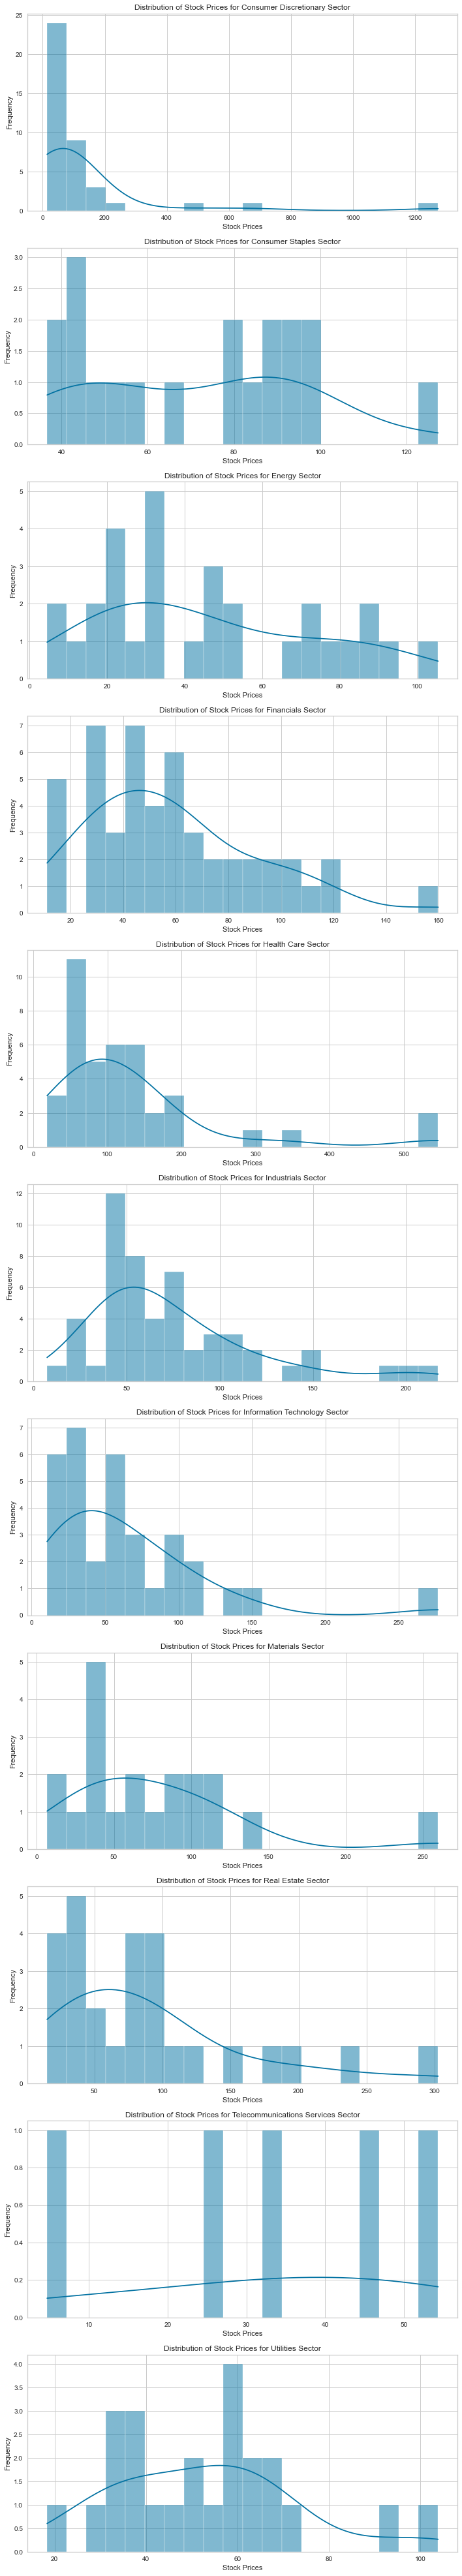

In [6]:
# Group the data by 'GICS Sector'
sector_groups = data.groupby('GICS Sector')

# Get the number of unique sectors for the loop
num_sectors = len(data['GICS Sector'].unique())

# Create subplots based on the number of sectors
fig, axes = plt.subplots(nrows=num_sectors, ncols=1, figsize=(10, 5*num_sectors))

# Loop through each sector group and plot the histogram
for i, (sector, sector_data) in enumerate(sector_groups):
    sns.histplot(data=sector_data, x='Current Price', bins=20, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of Stock Prices for {sector} Sector')
    axes[i].set_xlabel('Stock Prices')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Observations
- The distribution of stock prices vary across economics sectors but the majority of stocks in all sconomic sectors are below 200$
- The most of the distributions are right skewed which stands to reason as there are more small companies with low stock price than large companies with extremely valuble shares.
- This dataset is not a massive sample size and therefore certain sectors doent have many datapoints included (Telecommunications). In the future we would likely want a more robust dataset in order to do meaningful analysis.

## Data Preprocessing

- Duplicate value check
- Missing value treatment
- Outlier check
- Feature engineering (if needed)
- Any other preprocessing steps (if needed)

In [7]:
#look for missing values
#This function looks at each column and row in the dataset and outlines possible cleaning tasks. 
result= dqr(data=data, csv_engine='pandas', verbose=1)

#look for duplicates
column_names= data.columns.tolist()
duplicates=data.duplicated(subset=column_names, keep=False)
data[duplicates].sort_values('Ticker Symbol')

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
Ticker Symbol,object,0.000000,100,AAL,ZTS,"Possible ID colum: drop before modeling process., 340 rare categories: Too many to list. Group them into a single category or drop the categories., high cardinality with 340 unique values: Use hash encoding or embedding to reduce dimension."
Security,object,0.000000,100,3M Company,eBay Inc.,"Possible ID colum: drop before modeling process., 340 rare categories: Too many to list. Group them into a single category or drop the categories., high cardinality with 340 unique values: Use hash encoding or embedding to reduce dimension."
GICS Sector,object,0.000000,3,Consumer Discretionary,Utilities,1 rare categories: ['Telecommunications Services']. Group them into a single category or drop the categories.
GICS Sub Industry,object,0.000000,30,Advertising,Water Utilities,"104 rare categories: Too many to list. Group them into a single category or drop the categories., high cardinality with 104 unique values: Use hash encoding or embedding to reduce dimension."
Current Price,float64,0.000000,NA,4.500000,1274.949951,has 22 outliers greater than upper bound (174.3675035) or lower than lower bound(-42.93250249999999). Cap them or remove them.
Price Change,float64,0.000000,NA,-47.129693,55.051683,has 23 outliers greater than upper bound (28.147957057625003) or lower than lower bound(-18.391948249375). Cap them or remove them.
Volatility,float64,0.000000,NA,0.733163,4.580042,has 20 outliers greater than upper bound (2.536554822125) or lower than lower bound(0.2938723351250001). Cap them or remove them.
ROE,int64,0.000000,24,1,917,has 39 outliers greater than upper bound (52.875) or lower than lower bound(-16.125). Cap them or remove them.
Cash Ratio,int64,0.000000,36,0,958,has 16 outliers greater than upper bound (220.5) or lower than lower bound(-103.5). Cap them or remove them.
Net Cash Flow,int64,0.000000,97,-11208000000,20764000000,has 76 outliers greater than upper bound (715386625.0) or lower than lower bound(-739482375.0). Cap them or remove them.


,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio


#### Observations
- None of our columns have null values 
- There are no duplicate rows as the dataframe created to contain all duplicates returns an empty dataframe.

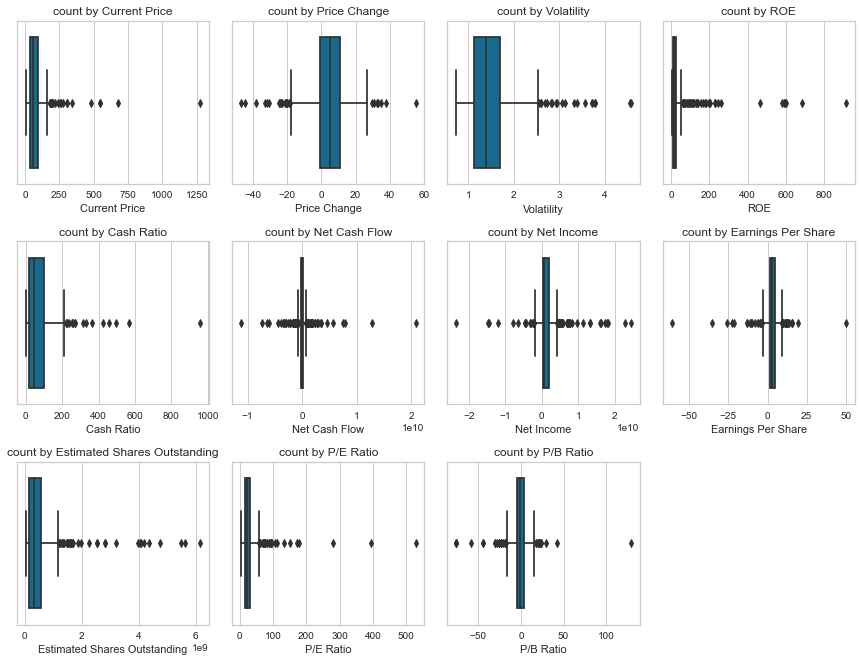

In [8]:
#Investigate outliers 
numeric_columns= data.select_dtypes(include='number').columns
num_data=data[numeric_columns]
fig = plt.figure(figsize=(12, 12))  

for i, var in enumerate(num_data):
    ax=fig.add_subplot(4,4, i+1)
    sns.boxplot(data=data, x=var)
    ax.set_title('count by {}'.format(var))  
    plt.tight_layout()    
plt.show()

#### Observations
- While all numeric variables contain outliers, there are no outliers that seem particularly outside the relm of possibility. Also it is reasonable to assume that stock prices, P/E ratios, and other metrics vary widly for different companies and outliers should be expected.
- These outliers could make clustering difficult but we cannot remove them as they do not seem to be mistakes and we can learn from them.

#### Scaling Data (must be done to compare columns with different variables)

In [9]:
#subset data into only numeric scalable columns 
subset=data.iloc[:,4:]
subset.head()

#use apply zscore to convert all vales to z-scores or # of standard deviations from the mean of that column
subset_scaled=subset.apply(zscore)
subset_scaled.head(10)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
0,-0.393341,0.493950,0.272749,0.989601,-0.210698,-0.339355,1.554415,1.309399,0.107863,-0.652487,-0.506653
1,-0.220837,0.355439,1.137045,0.937737,0.077269,-0.002335,0.927628,0.056755,1.250274,-0.311769,-0.504205
2,-0.367195,0.602479,-0.427007,-0.192905,-0.033488,0.454058,0.744371,0.024831,1.098021,-0.391502,0.094941
3,0.133567,0.825696,-0.284802,-0.317379,1.218059,-0.152497,-0.219816,-0.230563,-0.091622,0.947148,0.424333
4,-0.260874,-0.492636,0.296470,-0.265515,2.237018,0.133564,-0.202703,-0.374982,1.978399,3.293307,0.199196
5,-0.451251,-1.342556,-0.016049,-0.307006,-0.232849,-0.125823,0.090133,0.032432,0.048977,-0.459427,0.660752
6,1.998837,0.176091,-0.692132,-0.099549,-0.498664,0.018187,-0.228206,0.932390,-0.603923,-0.035502,9.377562
7,-0.384353,-0.158797,-0.679931,-0.317379,-0.620496,0.119096,-0.218177,-0.026856,-0.393572,-0.360984,0.071614
8,-0.230744,-0.142338,-0.774192,-0.296633,-0.675874,-0.021424,0.141806,0.053714,-0.183672,-0.319668,-0.093530
9,-0.214096,-0.087667,-0.808359,-0.265515,0.320933,-0.187053,0.263986,0.471769,-0.173153,-0.506408,-0.011879


## K-means Clustering

In [10]:
#copy data for k-means analysis
k_means_df = subset_scaled.copy()

Number of Clusters: 1 	Average Distortion: 2.5425069919221697
Number of Clusters: 2 	Average Distortion: 2.382318498894466
Number of Clusters: 3 	Average Distortion: 2.2692367155390745
Number of Clusters: 4 	Average Distortion: 2.1745559827866363
Number of Clusters: 5 	Average Distortion: 2.128799332840716
Number of Clusters: 6 	Average Distortion: 2.080400099226289
Number of Clusters: 7 	Average Distortion: 2.0289794220177395
Number of Clusters: 8 	Average Distortion: 1.964144163389972
Number of Clusters: 9 	Average Distortion: 1.9221492045198068
Number of Clusters: 10 	Average Distortion: 1.8513913649973124
Number of Clusters: 11 	Average Distortion: 1.8024134734578485
Number of Clusters: 12 	Average Distortion: 1.7900931879652673
Number of Clusters: 13 	Average Distortion: 1.7417609203336912
Number of Clusters: 14 	Average Distortion: 1.673559857259703


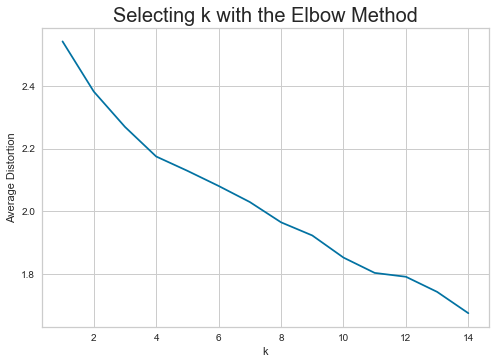

In [11]:
clusters = range(1, 15)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(subset_scaled)
    prediction = model.predict(k_means_df)
    distortion = (
        sum(np.min(cdist(k_means_df, model.cluster_centers_, "euclidean"), axis=1))
        / k_means_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)
plt.show()

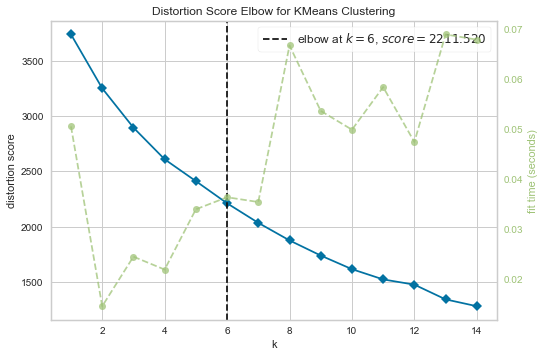

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(1, 15), timings=True)
visualizer.fit(k_means_df) 
visualizer.show()  

#### Observations
- While the distortion or within cluster sum of squares does reduce as expected with increasing number of clusters, there is no obvious elbow where the distortion score vastly diminishes.  
- Our second chart does show that the computational time required to complete the clustering makes a sizable jump from 7 to 8 clusters and therefore somewhere in this range may be a good selection as it will reduce the computation required for our model.

### Check Silhouette Scores

For n_clusters = 2, the silhouette score is 0.43969639509980457)
For n_clusters = 3, the silhouette score is 0.4644405674779403)
For n_clusters = 4, the silhouette score is 0.4577225970476733)
For n_clusters = 5, the silhouette score is 0.43228336443659804)
For n_clusters = 6, the silhouette score is 0.40054227372136175)
For n_clusters = 7, the silhouette score is 0.3976335364987305)
For n_clusters = 8, the silhouette score is 0.40278401969450467)
For n_clusters = 9, the silhouette score is 0.3778585981433699)
For n_clusters = 10, the silhouette score is 0.13458938329968687)
For n_clusters = 11, the silhouette score is 0.1421832155528444)
For n_clusters = 12, the silhouette score is 0.2044669621527429)
For n_clusters = 13, the silhouette score is 0.23424874810104204)
For n_clusters = 14, the silhouette score is 0.12102526472829901)


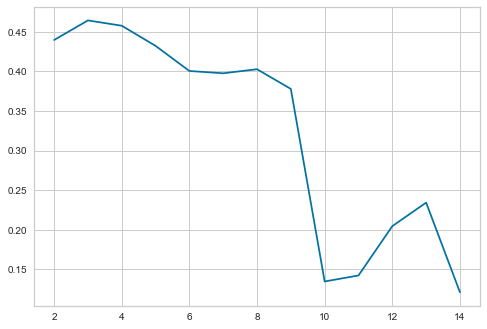

In [13]:
sil_score = []
cluster_list = range(2, 15)
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    preds = clusterer.fit_predict((subset_scaled))
    score = silhouette_score(k_means_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

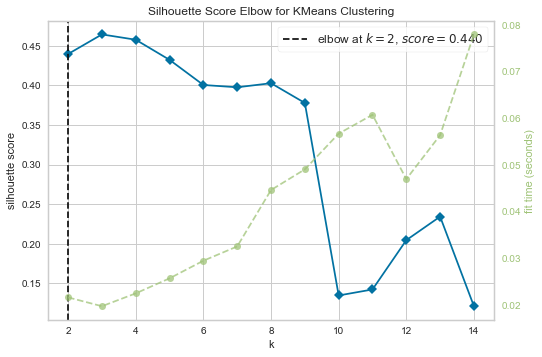

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [14]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2, 15), metric="silhouette", timings=True)
visualizer.fit(k_means_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure

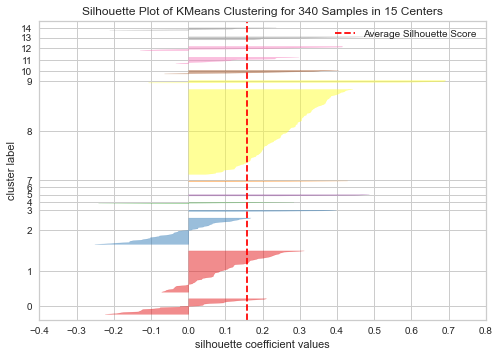

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 15 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [15]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(n_clusters=15, random_state=1))  
visualizer.fit(k_means_df)
visualizer.show()

#### Observations
- The silhouette score charts above show the highest scores around k or 3 to 4 but minimal loss of score up until k of 8. After k of 8 there is a massive drop off in silhouette score meaning that the clusters start to overlap at that point.
- Our second chart that maps each k value with a bar representing silhouette values. While this chart follows similar trends to the graph above a k of 7 likely maximizes the silhouette score, minimizes distortion score, and minimizes the computational requirments of building the model
- k=7 is the ideal number of clusters due to the reasons listed above.

### Final Model

In [16]:
# final K-means model
kmeans = KMeans(n_clusters=7, random_state=1)  
kmeans.fit(k_means_df)

KMeans(n_clusters=7, random_state=1)

In [17]:
# creating a copy of the original data
df1 = data.copy()

# adding kmeans cluster labels to the original and scaled dataframes
k_means_df["KM_segments"] = kmeans.labels_
df1["KM_segments"] = kmeans.labels_
print(df1.head())

  Ticker Symbol                 Security             GICS Sector  \
0           AAL  American Airlines Group             Industrials   
1          ABBV                   AbbVie             Health Care   
2           ABT      Abbott Laboratories             Health Care   
3          ADBE        Adobe Systems Inc  Information Technology   
4           ADI     Analog Devices, Inc.  Information Technology   

       GICS Sub Industry  Current Price  Price Change  Volatility  ROE  \
0               Airlines      42.349998      9.999995    1.687151  135   
1        Pharmaceuticals      59.240002      8.339433    2.197887  130   
2  Health Care Equipment      44.910000     11.301121    1.273646   21   
3   Application Software      93.940002     13.977195    1.357679    9   
4         Semiconductors      55.320000     -1.827858    1.701169   14   

   Cash Ratio  Net Cash Flow  Net Income  Earnings Per Share  \
0          51     -604000000  7610000000               11.39   
1          77     

### Cluster Profiling

In [18]:
#group by cluster labels 
km_cluster_profile = df1.groupby(df1["KM_segments"]).mean()  

In [19]:
km_cluster_profile["count_in_each_segment"] = (
    df1.groupby(df1["KM_segments"])["Security"].count().values
)

In [20]:
km_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,count_in_each_segment
KM_segments,,,,,,,,,,,,
0,72.196386,4.983796,1.368419,35.220974,50.149813,-2768119.850187,1510231314.606742,3.656124,429600138.717041,23.514365,-3.639469,267
1,50.517273,5.747586,1.130399,31.090909,75.909091,-1072272727.272727,14833090909.090910,4.154545,4298826628.727273,14.803577,-4.552119,11
2,74.479243,14.850168,1.794195,26.636364,303.045455,1594435500.000000,1641182272.727273,2.069091,812399104.022727,42.312548,7.685393,22
3,327.006671,21.917380,2.029752,4.000000,106.000000,698240666.666667,287547000.000000,0.750000,366763235.300000,400.989188,-5.322376,3
4,24.485001,-13.351992,3.482611,802.000000,51.000000,-1292500000.000000,-19106500000.000000,-41.815000,519573983.250000,60.748608,1.565141,2
5,34.231808,-15.515565,2.832069,48.037037,47.740741,-128651518.518519,-2444318518.518518,-6.284444,503031539.057037,75.627265,1.655990,27
6,508.534992,5.732177,1.504640,27.250000,150.875000,37895875.000000,1116994125.000000,15.965000,75654420.935000,43.727459,29.581664,8


In [21]:
## Print the companies in each cluster
for cl in df1["KM_segments"].unique():
    print("In cluster {}, the following companies are present:".format(cl))
    print(df1[df1["KM_segments"] == cl]["Security"].unique())
    print()

In cluster 0, the following companies are present:
['American Airlines Group' 'AbbVie' 'Abbott Laboratories'
 'Archer-Daniels-Midland Co' 'Ameren Corp' 'American Electric Power'
 'AFLAC Inc' 'American International Group, Inc.'
 'Apartment Investment & Mgmt' 'Assurant Inc' 'Arthur J. Gallagher & Co.'
 'Akamai Technologies Inc' 'Albemarle Corp' 'Alaska Air Group Inc'
 'Allstate Corp' 'Allegion' 'AMETEK Inc' 'Affiliated Managers Group Inc'
 'Ameriprise Financial' 'American Tower Corp A' 'AutoNation Inc'
 'Anthem Inc.' 'Aon plc' 'Amphenol Corp' 'Activision Blizzard'
 'AvalonBay Communities, Inc.' 'American Water Works Company Inc'
 'American Express Co' 'Boeing Company' 'Baxter International Inc.'
 'BB&T Corporation' 'Bard (C.R.) Inc.' 'The Bank of New York Mellon Corp.'
 'Ball Corp' 'Bristol-Myers Squibb' 'Boston Scientific' 'BorgWarner'
 'Boston Properties' 'Caterpillar Inc.' 'Chubb Limited' 'CBRE Group'
 'Crown Castle International Corp.' 'Carnival Corp.'
 'CF Industries Holdings Inc' 

In [22]:
df1.groupby(["KM_segments", "GICS Sector"])['Security'].count()

KM_segments  GICS Sector                
0            Consumer Discretionary         33
             Consumer Staples               17
             Energy                          5
             Financials                     45
             Health Care                    28
             Industrials                    51
             Information Technology         19
             Materials                      17
             Real Estate                    26
             Telecommunications Services     2
             Utilities                      24
1            Consumer Discretionary          1
             Consumer Staples                1
             Energy                          1
             Financials                      3
             Health Care                     2
             Information Technology          1
             Telecommunications Services     2
2            Consumer Discretionary          3
             Consumer Staples                1
             Energy

#### Observations
- The clusters created by our k-means clustering model are not as evenly spread as would be ideal but we must remember that these clusters are spupposed to group stocks by similarity, not just create clusters that all have the same number of stocks
- The clusterings have little to do with economic sector as there is great variation in this metric between groups. This makes sense as the model was built with the companies financial data as opposed to data on the products and services they provide. 

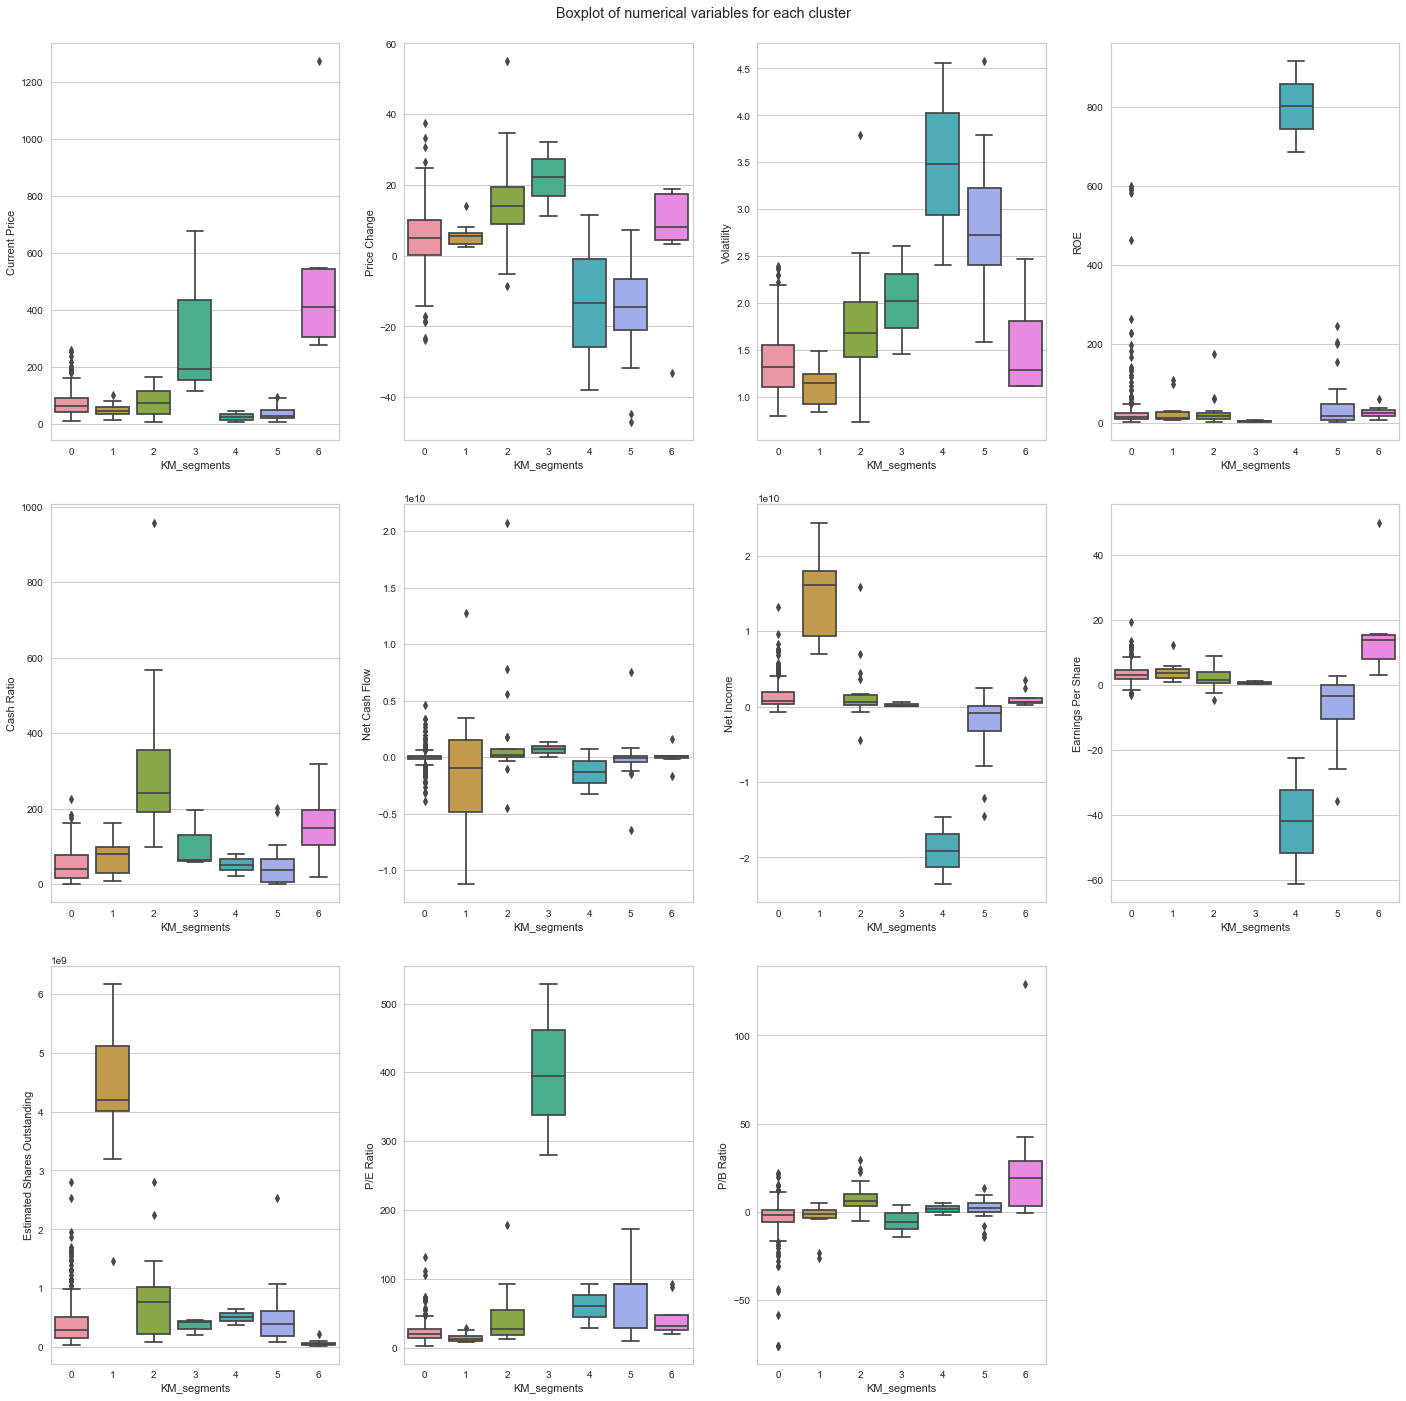

In [23]:
plt.figure(figsize=(20, 20))
plt.suptitle("Boxplot of numerical variables for each cluster")

# selecting numerical columns
num_col = subset_scaled.select_dtypes(include=np.number).columns.tolist()

for i, var in enumerate(num_col):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data=df1, x="KM_segments", y=var)

plt.tight_layout(pad=2.0)

### Insights
- While one may think that the clusters would include companies of the same general type of industry, they actually have a great deal of variety in each cluster with companies from a variety of sectors. This is likely due to the fact that the data were using to cluster is financial. This means that companies with similar profitablity, value, and price to earnings are grouped as opposed to companies that sell similar products and services.
- The boxplots above indicate that many of the categories have a clear standout for each clustering. For example we can see that cluster 4 has a ROEs far higher than any other group. This would likely be a a cluster to look into more when considering investments. 
- In an ideal model we would like to have the stocks slightly more evenly distributed. We will attempt to find a better distribution using hierarcical clustering below. 

## Hierarchical Clustering

In [24]:
#create new scaled dataframe copy for hierarchical clustering
hc_df = subset_scaled.copy()

### Computing Cophenetic Correlation

In [25]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(hc_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(hc_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm
            
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print('*'*100)
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Cophenetic correlation for Euclidean distance and single linkage is 0.9232271494002922.
Cophenetic correlation for Euclidean distance and complete linkage is 0.7873280186580672.
Cophenetic correlation for Euclidean distance and average linkage is 0.9422540609560814.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8693784298129404.
Cophenetic correlation for Chebyshev distance and single linkage is 0.9062538164750717.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.598891419111242.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9338265528030499.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9127355892367.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.9259195530524591.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.7925307202850004.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.9247324030159737.
Cophenetic correl

**The Cophenetic correlation using Eucladian distance was on average higher than other distance measures and therefore we should use Eucladian distance in our final grouping.**

In [26]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]   

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(hc_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(hc_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm
        
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print('*'*100)
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Cophenetic correlation for single linkage is 0.9232271494002922.
Cophenetic correlation for complete linkage is 0.7873280186580672.
Cophenetic correlation for average linkage is 0.9422540609560814.
Cophenetic correlation for centroid linkage is 0.9314012446828154.
Cophenetic correlation for ward linkage is 0.7101180299865353.
Cophenetic correlation for weighted linkage is 0.8693784298129404.
****************************************************************************************************
Highest cophenetic correlation is 0.9422540609560814, which is obtained with average linkage.


**We see that the cophenetic correlation is maximum with Euclidean distance and average linkage.**

### Checking Dendrograms for different linkage methods

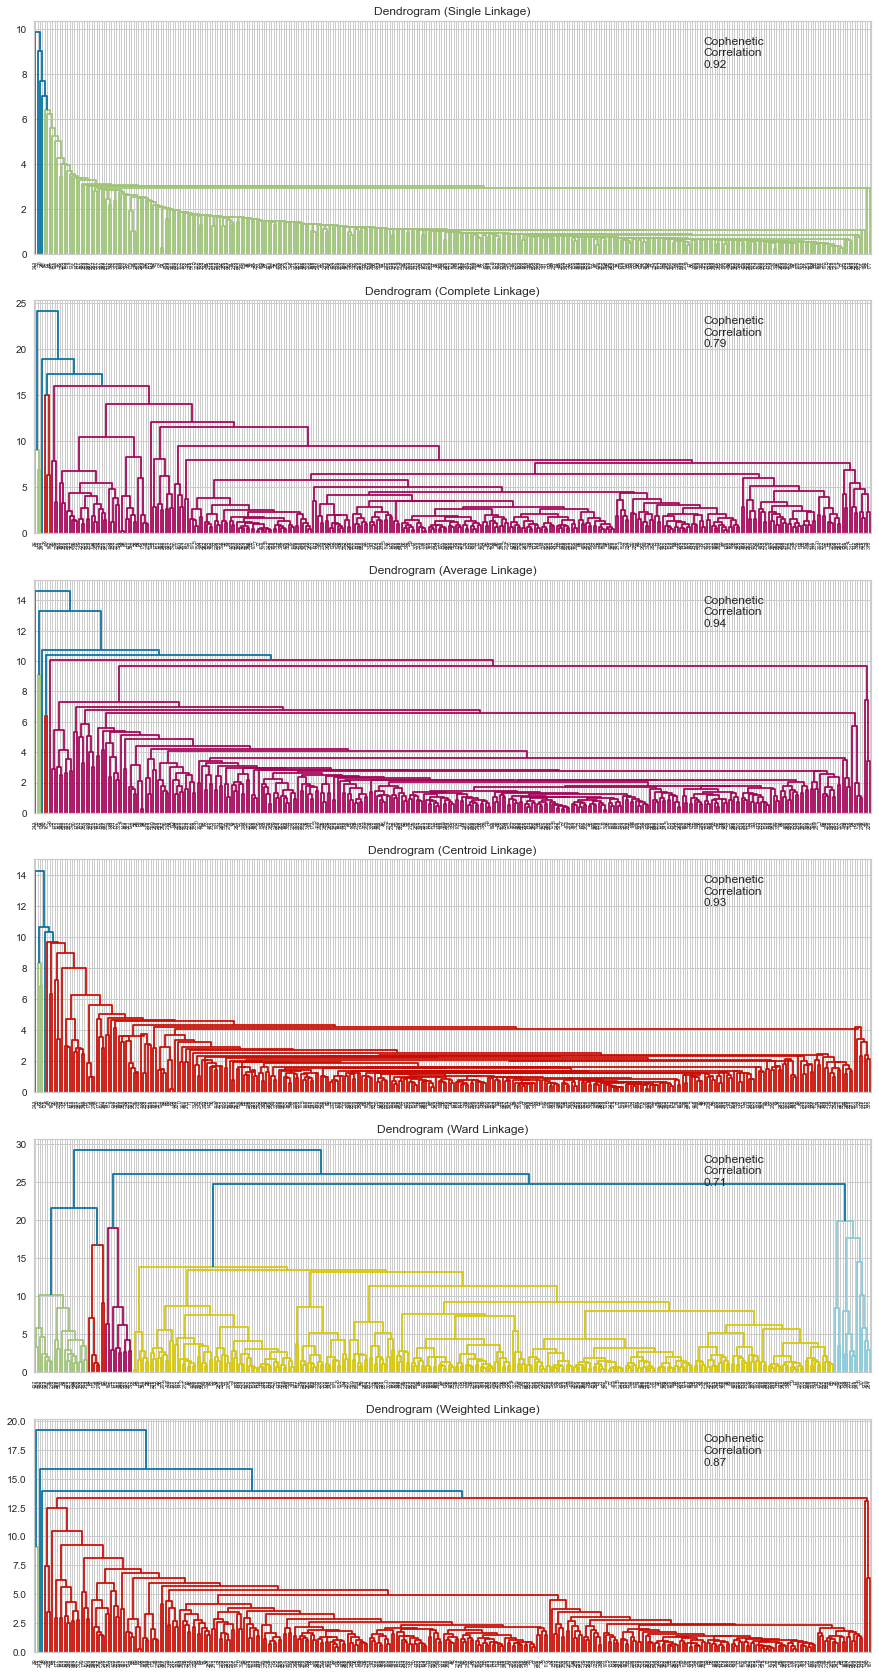

In [27]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]  

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(hc_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(hc_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

In [28]:
# create and print a dataframe to compare cophenetic correlations for different linkage methods
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc = df_cc.sort_values(by="Cophenetic Coefficient")
df_cc

,Linkage,Cophenetic Coefficient
4,ward,0.710118
1,complete,0.787328
5,weighted,0.869378
0,single,0.923227
3,centroid,0.931401
2,average,0.942254


#### Observations 
- The highest cophenetic correlation is using average and centroid linkage methods.
- When looking that the dendrograms the models with the highest cophenetic value will cause groupings in which one cluster contains the vast majority of stocks. We want to seperate stocks more evenly to assess their qualities and therefore should use visual analysis of dendrograms to choose the number of clusters as opposed to the cophenetic correnlation.
- Our ward linkage and complete linkage dendromgrams do the best job with this. Therefore we will use one of these models in our final model and use the diagrams to select the number of clusters
- The ward linkage dendrogram evenly groups companies if we visually select a cluster distance of around 14. this distance corresponds to a **cluster number of 14** as well. this is the k value we will use in our final model.

#### Creating Algolomerative model using sklearn

In [29]:
#build hierarcical cluster model
HCmodel = AgglomerativeClustering(n_clusters=14, affinity='euclidean', linkage='ward')  
HCmodel.fit(hc_df)

AgglomerativeClustering(n_clusters=14)

In [30]:
# creating a copy of the original data
df2 = data.copy()

# Adding hierarchical cluster labels to the original and scaled dataframes
hc_df["HC_segments"] = HCmodel.labels_
df2["HC_segments"] = HCmodel.labels_

### Cluster Profiling

In [31]:
# group data by clusters
hc_cluster_profile = df2.groupby("HC_segments").mean().reset_index()  

In [32]:
#visualize means of columns for each cluster
hc_cluster_profile["count_in_each_segment"] = (
    df2.groupby("HC_segments")["Security"].count().values 
)

In [33]:
hc_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,HC_segments,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,count_in_each_segment
0,0,36.440455,-16.073408,2.832884,57.500000,42.409091,-472834090.909091,-3161045227.272727,-8.005000,514367806.201818,85.555682,0.836839,22
1,1,429.569995,3.761200,1.565483,18.000000,174.400000,362405800.000000,496954600.000000,9.900000,59200701.450000,55.569866,46.627828,5
2,2,51.839641,13.061837,1.772744,20.016949,91.711864,-292614983.050847,1332173118.644068,1.922203,718503003.122203,28.315828,1.618133,59
3,3,24.485001,-13.351992,3.482611,802.000000,51.000000,-1292500000.000000,-19106500000.000000,-41.815000,519573983.250000,60.748608,1.565141,2
4,4,79.466714,5.155097,1.260725,25.685393,47.640449,-36521016.853933,1208199657.303371,3.870393,332254252.671404,24.838040,-2.905371,178
5,5,46.672222,5.166566,1.079367,25.000000,58.333333,-3040666666.666667,14848444444.444445,3.435556,4564959946.222222,15.596051,-6.354193,9
6,6,78.074210,4.770519,1.177668,58.157895,73.210526,1826347368.421053,6359636842.105263,7.023421,992223453.415790,14.465865,-4.748483,19
7,7,81.525556,11.783328,1.575565,14.166667,544.666667,349565833.333333,1178117333.333333,2.490000,1121045865.050000,31.693323,11.835447,6
8,8,108.304002,10.737770,1.165694,566.200000,26.600000,-278760000.000000,687180000.000000,1.548000,349607057.720000,34.898915,-16.851358,5
9,9,1274.949951,3.190527,1.268340,29.000000,184.000000,-1671386000.000000,2551360000.000000,50.090000,50935516.070000,25.453183,-1.052429,1


In [34]:
## Complete the code to print the companies in each cluster
for cl in df2["HC_segments"].unique():
    print("In cluster {}, the following companies are present:".format(cl))
    print(df2[df2["HC_segments"] == cl]["Security"].unique())
    print()

In cluster 6, the following companies are present:
['American Airlines Group' 'BB&T Corporation'
 'Discover Financial Services' 'The Walt Disney Company' 'Exelon Corp.'
 'Gilead Sciences' 'International Business Machines' "McDonald's Corp."
 'Mondelez International' 'MetLife Inc.' 'Altria Group Inc'
 'Northern Trust Corp.' 'PepsiCo Inc.' 'Philip Morris International'
 'Prudential Financial' 'United Continental Holdings'
 'United Health Group Inc.' 'United Parcel Service' 'United Technologies']

In cluster 2, the following companies are present:
['AbbVie' 'Abbott Laboratories' 'Adobe Systems Inc'
 'American International Group, Inc.' 'Albemarle Corp'
 'Applied Materials Inc' 'Arconic Inc' 'Activision Blizzard' 'Broadcom'
 'The Bank of New York Mellon Corp.' 'Bristol-Myers Squibb'
 'Boston Scientific' 'BorgWarner' 'Celgene Corp.' 'Comerica Inc.'
 'Centene Corporation' 'Citrix Systems' 'Chevron Corp.' 'Du Pont (E.I.)'
 'eBay Inc.' 'E*Trade' 'Edwards Lifesciences' 'Fastenal Co' 'FLIR Syste

In [35]:
#count companies per economic sector per cluster
df2.groupby(["HC_segments", "GICS Sector"])['Security'].count()

HC_segments  GICS Sector                
0            Energy                         20
             Information Technology          1
             Materials                       1
1            Consumer Discretionary          1
             Health Care                     2
             Information Technology          1
             Real Estate                     1
2            Consumer Discretionary          8
             Energy                          2
             Financials                     10
             Health Care                    11
             Industrials                     6
             Information Technology         16
             Materials                       5
             Real Estate                     1
3            Energy                          2
4            Consumer Discretionary         18
             Consumer Staples               10
             Energy                          3
             Financials                     26
             Health

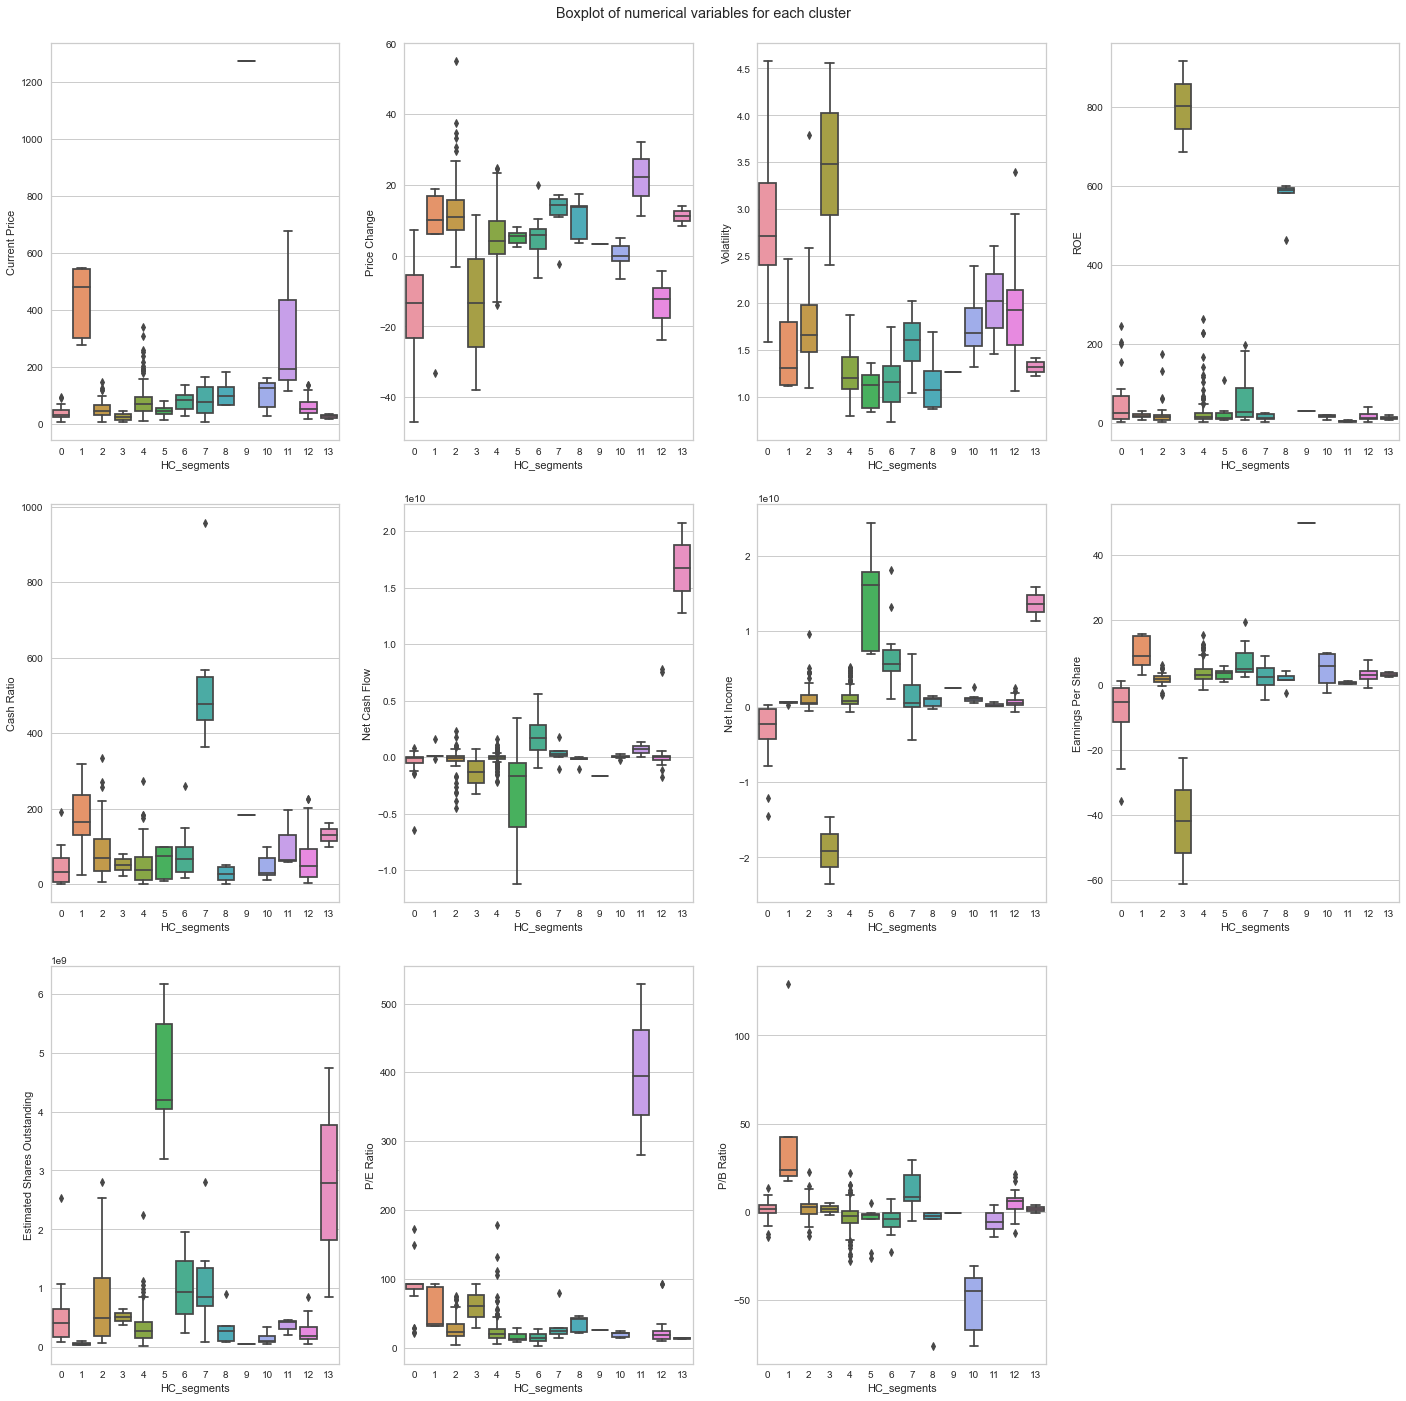

In [36]:
plt.figure(figsize=(20, 20))
plt.suptitle("Boxplot of numerical variables for each cluster")

for i, var in enumerate(num_col):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data=df2, x="HC_segments", y=var)

plt.tight_layout(pad=2.0)

#### Observations
- After testing both complete and ward linkage methods each with a range of cluster counts, I determined that using ward linkage and a k value of 14 returned clusters that contain fairly evenly distributed companies. The companies in each category also seem to share similarities in terms of their size and/or industry which is a good sign that the suctering is effective. We will investigate this further in our final analysis
- **Cluster 0**
   - This cluster is primarily companies in the energy sector. The fact that 20 out of 21 stocks in this sector are energy companies is a great indication that our clustering did manage to find similar groupings.  
   - These stocks have not performed well based on our dataset as they have high volitility and mostly negative earnings per share 
- **Cluster 2**
   - This cluster of companies from a range of indistries with the majority coming from financial, IT, and Health care industries.
   - This cluster does not stand out from others in many ways with slightly positive net income, earnings per share, and cash ratio.
   - This cluster also has low volitility and price to earnings ratio which indicates some stocks in this cluster could be safe. Low risk, investments. We could perhaps build a ETF or mutual fund based around these stocks.
   
- **Cluster 4**
   - This cluster shares the same characteristics as cluster two with a greater variety of industries included in its stocks.
   - This cluster would be a good choice for investors looking for low risk investments.
   
- **Cluster 6**
   - This cluster shares the same characteristics as cluster two with a greater variety of industries included in its stocks.
   - The cluster has higher cash ratios and net income than other clusters with low price volatility, making it an excelent cluster for investments
   - Includes a number of well know companies such as Pepsi, Discover, and Philip Morris.
   
- **Cluster 12**
   - This cluster shares the same characteristics as cluster two with a greater variety of industries included in its stocks.
   - Due to negative average price change and reasonably high volitility which indicates this cluster is likely not the best place to look for investments
   

## K-means vs Hierarchical Clustering

Our final **hierarchcal clustering model returned superior clusters** to our K-means clusting model due to the more even distribution of their stocks and the clear commonalities between companies within promenant clusters in terms of industry, price, and other financial metrics.

- Which clustering technique took less time for execution and which clustering technique gave you more distinct clusters, or are they the same?
    - While K-means clustering is a faster method of clustering and less computationally intensive, in this case hierarchical clustering provided better clusters.  Due to our dataset being fairly small, hierarchical is a reasonable option in this case as the computational requirments are not unreasonable and the models and run quickly.

- How many observations are there in the similar clusters of both algorithms and how many clusters are obtained as the appropriate number of clusters from both algorithms?
    - K-means clustering and hierarchcal clustering models returned clusters that shared little overlap. The K-means clusters seemed to have no real similarities between the companies in its clusters while the hierarchical models clusters share similar characteristics and industries between companies. I elected to use 6 clusters in the k means model due to the silhouette score and low computing requirement at that level. I elected to use 14 clusters in the hierarchical model as the dendrogram for ward linkage indicated that this was the ideal number to distribute stocks across clusters.   

## Actionable Insights and Recommendations
**Overivew:** Due to our dataset including mostly financial data on the companies listed we must understand that our results group stocks based on these characteristics. All the insights and recommendations below have nothing to due with macroeconomic and socioeconomic factors that influence particular industries differently.  Our recommendations should be used with caution and only to assess investment into indexes or groups of stocks (mutual funds/ ETFs)as opposed to indivisual companies.

**Recommendations (All based on hierarchical clustering model):**
- Cluster 1 energy stocks have not performed well. They have high volitility and mostly negative earnings per share and should be avoided by investors.
    - Based on our exploritory data analysis, energy sector stocks should be completely avoided by investors due to high volatility, negative earnings per share, and an extremely high P/E ratio.  

- Clusters 2, 4 and 6 are an excellent choice for investment as they have a range of companies acorss different industries that produce net positive income, earnings per share and cash ratio. The low volatility of these clusters make them consistant and low risk. Spreading investment across these cluster or indexs would be a wise choise. That being said they are also unlikely to produce massive gain. 

- Cluster 12 stocks should likely be avoided or at least investigated thuroughly before being considered for investment.  This cluster has negative price change and high volitility making it a poor choice.

**General recomendations:**
- Based on our exploritory data analysis, health care, IT, and Consumer staple stocks are excellent sectors to investigate as they all have positive cash ratios, significant growth, reasonable price to earnings ratios and return on investment.  While thay dont necessarily lead every one of the sectors across all these metrics, they have little signs of weakness.  That being said they all have significant volitility so it would be wise to wait for a dip in price before buying into these markets or do dep research on individual stocks before buying in.

- The financial sector cluster also shows signs of being and excellent investment vehicle as its metrics are all strong. Its average share price is also lower that the previously mentioned sectors making it an easier entry point for investors looking to only buy a few shares. 